In [1]:
import creds
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cointegration.funcs import * 

tok = creds.token_ro_all

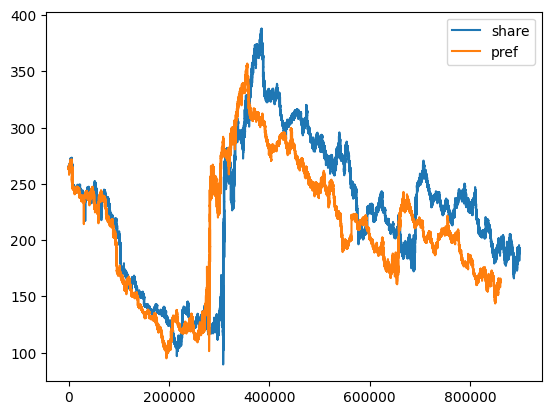

In [2]:
ticker = 'SBER'
share = pd.read_csv(f'../data/shares_data/companies/{ticker}.csv')
pref = pd.read_csv(f'../data/shares_data/companies_pref/{ticker}P.csv')

plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
plt.legend()

Time Series1:  4.5% is missing (899121 ==> 859080)
Time Series2:  0.2% is missing (860938 ==> 859080)


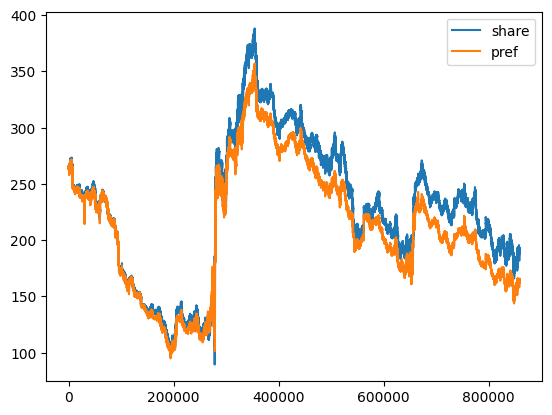

In [3]:
share, pref = match_ts(share, pref)

plt.plot(share['close'], label='share')
plt.plot(pref['close'], label='pref')
plt.legend()

(-5.0, 17.0)

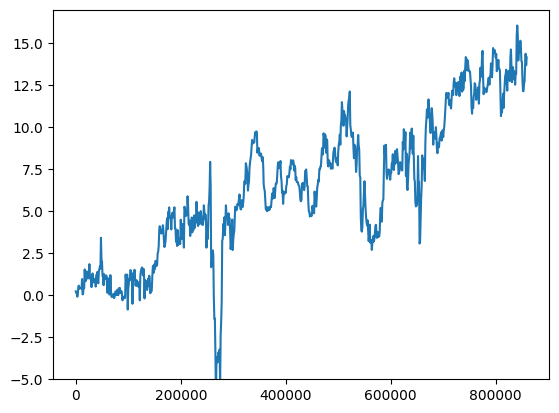

In [10]:
diff = 100*(share['close'] - pref['close']) / share['close']
plt.plot(diff[::1000], label='pref')
plt.ylim(-5, 17)